<a href="https://colab.research.google.com/github/1ceXCube/Algoritma-Dan-Pemograman/blob/main/Resnet_50%20%26%20MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Sesuaikan path ini dengan lokasi dataset Anda di Google Drive
base_dir = '/content/drive/MyDrive/GuavaDiseaseDataset'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Konfigurasi Model
IMG_SIZE = (224, 224) # Ukuran input untuk ResNet dan MobileNet
BATCH_SIZE = 32
NUM_CLASSES = 3 # anthracnose, fruit_fly, healthy_guava

In [ ]:
# @title 3. Preprocessing dan Augmentasi Data
print("Menyiapkan Data Generator...")

# Augmentasi untuk data training untuk mencegah overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Untuk data validasi dan tes, kita hanya melakukan rescale
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False) # Penting: Jangan di-shuffle untuk evaluasi

# Cek nama kelas
class_names = list(train_generator.class_indices.keys())
print("\nKelas yang ditemukan:", class_names)

Menyiapkan Data Generator...
Found 1800 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.

Kelas yang ditemukan: ['Anthracnose', 'fruit_fly', 'healthy_guava']


In [ ]:
# @title 4. Membangun dan Melatih Model ResNet-50
print("--- Memulai Proses untuk Model ResNet-50 ---")
# Muat model dasar ResNet-50
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model_resnet.trainable = False

# Tambahkan lapisan klasifikasi kustom
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Kompilasi model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Tambahkan Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


print("\nMemulai Pelatihan Model ResNet-50...")
history_resnet = model_resnet.fit(
    train_generator,
    epochs=100, # Anda bisa sesuaikan jumlah epoch
    validation_data=validation_generator,
    callbacks=[early_stopping] # Tambahkan callback di sini
)

--- Memulai Proses untuk Model ResNet-50 ---

Memulai Pelatihan Model ResNet-50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3495 - loss: 1.2781

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 807s 14s/step - accuracy: 0.3496 - loss: 1.2774 - val_accuracy: 0.4889 - val_loss: 1.0282
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 944ms/step - accuracy: 0.3594 - loss: 1.1592 - val_accuracy: 0.5567 - val_loss: 0.9757
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 978ms/step - accuracy: 0.3801 - loss: 1.1380 - val_accuracy: 0.5922 - val_loss: 0.9407
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 945ms/step - accuracy: 0.4096 - loss: 1.0910 - val_accuracy: 0.6244 - val_loss: 0.9098
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 918ms/step - accuracy: 0.4620 - loss: 1.0357 - val_accuracy: 0.5333 - val_loss: 0.9343
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4753 - loss: 1.0147 - val_accuracy: 0.6567 - val_loss: 0.8781
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 964ms/step - accuracy: 0.4726 - loss: 1.0053 - val_accuracy: 0.6622 - val_loss: 0.8608
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 944ms/step - accuracy: 0.5193 - loss: 0.9739 - val_accuracy: 0.


--- Mengevaluasi Model ResNet-50 ---


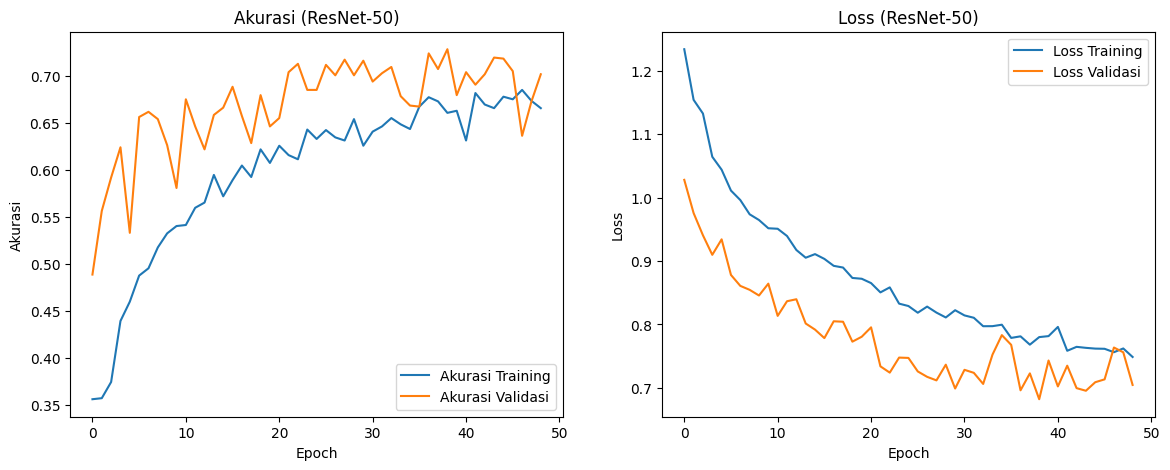


Evaluasi pada data test (ResNet-50):


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 148s 16s/step - accuracy: 0.7395 - loss: 0.6750
Test Accuracy (ResNet-50): 71.67%

Laporan Klasifikasi (ResNet-50):
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 661ms/step
               precision    recall  f1-score   support

  Anthracnose       0.66      0.77      0.71       100
    fruit_fly       0.74      0.67      0.70       100
healthy_guava       0.76      0.71      0.74       100

     accuracy                           0.72       300
    macro avg       0.72      0.72      0.72       300
 weighted avg       0.72      0.72      0.72       300


Confusion Matrix (ResNet-50):


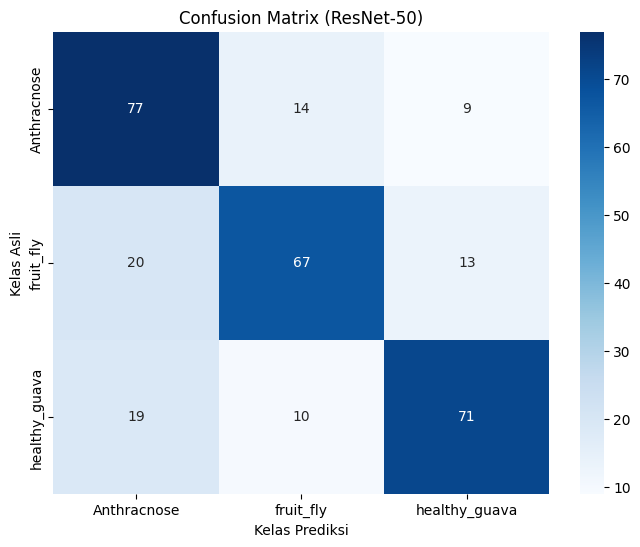


Model ResNet-50 telah disimpan sebagai 'guava_classifier_resnet50.h5'


In [ ]:
# @title 5. Evaluasi Lengkap Model ResNet-50
print("\n--- Mengevaluasi Model ResNet-50 ---")

# 1. Plot Grafik Performa
acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']
loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']
epochs_range_resnet = range(len(acc_resnet))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_resnet, acc_resnet, label='Akurasi Training')
plt.plot(epochs_range_resnet, val_acc_resnet, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi (ResNet-50)')
plt.xlabel('Epoch'); plt.ylabel('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_resnet, loss_resnet, label='Loss Training')
plt.plot(epochs_range_resnet, val_loss_resnet, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss (ResNet-50)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()

# 2. Evaluasi Final & Laporan Klasifikasi pada Data Test
print("\nEvaluasi pada data test (ResNet-50):")
test_generator.reset() # Reset generator sebelum prediksi
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_generator)
print(f"Test Accuracy (ResNet-50): {test_acc_resnet*100:.2f}%")

print("\nLaporan Klasifikasi (ResNet-50):")
test_generator.reset() # Reset lagi untuk memastikan urutan
y_pred_probs_resnet = model_resnet.predict(test_generator)
y_pred_resnet = np.argmax(y_pred_probs_resnet, axis=1)
y_true_resnet = test_generator.classes
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))

# 3. Matriks Kebingungan (Confusion Matrix)
print("\nConfusion Matrix (ResNet-50):")
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (ResNet-50)')
plt.ylabel('Kelas Asli'); plt.xlabel('Kelas Prediksi')
plt.show()

# 4. Simpan Model
model_resnet.save('guava_classifier_resnet50.h5')
print("\nModel ResNet-50 telah disimpan sebagai 'guava_classifier_resnet50.h5'")

In [ ]:
# @title 6. Membangun & Melatih MobileNetV2 dengan Fine-Tuning
print("\n\n--- Memulai Proses untuk Model MobileNetV2 dengan Teknik Lanjutan ---")

# ==================================
# TAHAP 1: Latih "Kepala" Model
# ==================================
print("--- TAHAP 1: Membangun Model dan Melatih Head ---")
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model_mobilenet.trainable = False

y = base_model_mobilenet.output
y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
y = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(y) # Tambah L2 Regularizer
predictions_mobilenet = Dense(NUM_CLASSES, activation='softmax')(y)
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobilenet)

model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Definisikan Callbacks untuk mengontrol pelatihan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

print("\nMemulai pelatihan kepala model...")
history_head = model_mobilenet.fit(
    train_generator,
    epochs=100, # Epochs maksimal untuk tahap ini
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# ==================================
# TAHAP 2: Fine-Tuning
# ==================================
print("\n--- TAHAP 2: Memulai Fine-Tuning ---")
base_model_mobilenet.trainable = True
fine_tune_at = 100
for layer in base_model_mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang dengan learning rate yang sangat kecil
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

print(f"\nMelanjutkan pelatihan untuk fine-tuning...")
fine_tune_epochs = 15
total_epochs = len(history_head.epoch) + fine_tune_epochs

history_fine_tune = model_mobilenet.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=len(history_head.epoch),
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)



--- Memulai Proses untuk Model MobileNetV2 dengan Teknik Lanjutan ---
--- TAHAP 1: Membangun Model dan Melatih Head ---

Memulai pelatihan kepala model...
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5924 - loss: 2.0254 - val_accuracy: 0.8589 - val_loss: 1.4892 - learning_rate: 1.0000e-04
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 879ms/step - accuracy: 0.9064 - loss: 1.3920 - val_accuracy: 0.9222 - val_loss: 1.3246 - learning_rate: 1.0000e-04
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 894ms/step - accuracy: 0.9172 - loss: 1.2972 - val_accuracy: 0.9078 - val_loss: 1.2856 - learning_rate: 1.0000e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 892ms/step - accuracy: 0.9443 - loss: 1.2039 - val_accuracy: 0.9167 - val_loss: 1.2268 - learning_rate: 1.0000e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9319 - loss: 1.1939 - val_accuracy: 0.9156 - val_loss: 1.1875 - learning_rate: 1.0000e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 912ms/step - acc


--- Mengevaluasi Model MobileNetV2 ---


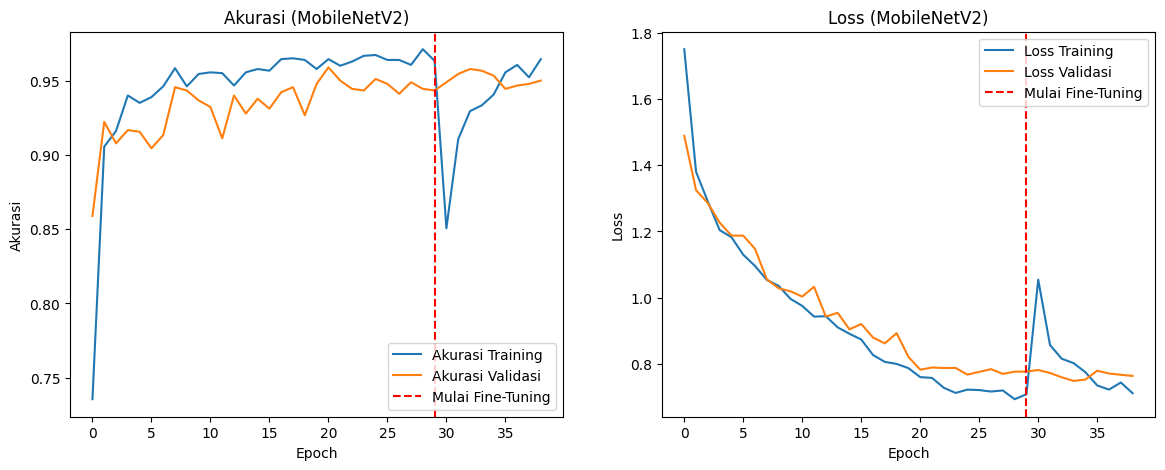


Evaluasi pada data test (MobileNetV2):
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.9694 - loss: 0.7111
Test Accuracy (MobileNetV2): 96.00%

Laporan Klasifikasi (MobileNetV2):
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 671ms/step
               precision    recall  f1-score   support

  Anthracnose       0.95      0.99      0.97       100
    fruit_fly       0.98      0.92      0.95       100
healthy_guava       0.95      0.97      0.96       100

     accuracy                           0.96       300
    macro avg       0.96      0.96      0.96       300
 weighted avg       0.96      0.96      0.96       300


Confusion Matrix (MobileNetV2):


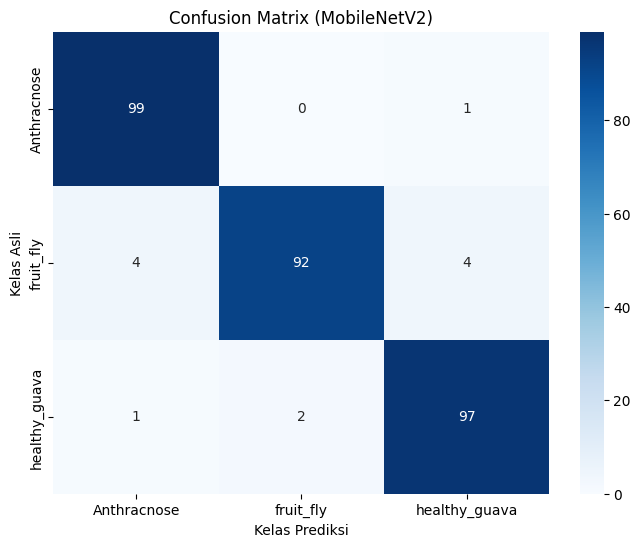


Model MobileNetV2 (fine-tuned) telah disimpan sebagai 'guava_classifier_mobilenetv2_finetuned.h5'


In [ ]:
# @title 7. Evaluasi Lengkap Model MobileNetV2
print("\n--- Mengevaluasi Model MobileNetV2 ---")

# 1. Gabungkan history & Plot Grafik Performa
acc = history_head.history['accuracy'] + history_fine_tune.history.get('accuracy', [])
val_acc = history_head.history['val_accuracy'] + history_fine_tune.history.get('val_accuracy', [])
loss = history_head.history['loss'] + history_fine_tune.history.get('loss', [])
val_loss = history_head.history['val_loss'] + history_fine_tune.history.get('val_loss', [])
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Training')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.axvline(x=len(history_head.epoch)-1, color='r', linestyle='--', label='Mulai Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Akurasi (MobileNetV2)')
plt.xlabel('Epoch'); plt.ylabel('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Training')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.axvline(x=len(history_head.epoch)-1, color='r', linestyle='--', label='Mulai Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Loss (MobileNetV2)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()


# 2. Evaluasi Final & Laporan Klasifikasi pada Data Test
print("\nEvaluasi pada data test (MobileNetV2):")
test_generator.reset()
test_loss_mobilenet, test_acc_mobilenet = model_mobilenet.evaluate(test_generator)
print(f"Test Accuracy (MobileNetV2): {test_acc_mobilenet*100:.2f}%")

print("\nLaporan Klasifikasi (MobileNetV2):")
test_generator.reset()
y_pred_probs_mobilenet = model_mobilenet.predict(test_generator)
y_pred_mobilenet = np.argmax(y_pred_probs_mobilenet, axis=1)
y_true_mobilenet = test_generator.classes
print(classification_report(y_true_mobilenet, y_pred_mobilenet, target_names=class_names))

# 3. Matriks Kebingungan (Confusion Matrix)
print("\nConfusion Matrix (MobileNetV2):")
cm_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_mobilenet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (MobileNetV2)')
plt.ylabel('Kelas Asli'); plt.xlabel('Kelas Prediksi')
plt.show()

# 4. Simpan Model
model_mobilenet.save('guava_classifier_mobilenetv2_finetuned.h5')
print("\nModel MobileNetV2 (fine-tuned) telah disimpan sebagai 'guava_classifier_mobilenetv2_finetuned.h5'")

In [ ]:
# @title 8. Perbandingan Final dan Rekomendasi untuk Android
# Mendapatkan ukuran file model yang disimpan
try:
    size_resnet = os.path.getsize('guava_classifier_resnet50.h5') / (1024 * 1024)
    size_mobilenet = os.path.getsize('guava_classifier_mobilenetv2_finetuned.h5') / (1024 * 1024)

    print("=========================================================")
    print("             PERBANDINGAN HASIL AKHIR MODEL              ")
    print("=========================================================")
    print(f"| Metric            | ResNet-50          | MobileNetV2 (Fine-Tuned) |")
    print(f"|-------------------|--------------------|--------------------------|")
    print(f"| Test Accuracy     | {test_acc_resnet*100:^18.2f}% | {test_acc_mobilenet*100:^24.2f}% |")
    print(f"| Ukuran Model (MB) | {size_resnet:^18.2f} | {size_mobilenet:^24.2f} |")
    print("=========================================================")

    print("\n### Rekomendasi untuk Sistem Android ###\n")
    print("Untuk aplikasi Android, prioritas utama adalah **ukuran model yang kecil** dan **kecepatan inferensi (prediksi) yang tinggi**.")
    print("\n**MobileNetV2 adalah pemenangnya untuk deployment di perangkat mobile.**")
    print("Alasan:")
    print(f"- **Ukuran Jauh Lebih Kecil**: MobileNetV2 ({size_mobilenet:.2f} MB) secara signifikan lebih ringan daripada ResNet-50 ({size_resnet:.2f} MB). Ini membuat ukuran total aplikasi Anda lebih kecil.")
    print(f"- **Lebih Cepat**: Arsitektur MobileNetV2 dirancang khusus untuk efisiensi di perangkat mobile, sehingga akan memberikan prediksi yang lebih cepat dan pengalaman pengguna yang lebih baik.")
    print(f"- **Akurasi Kompetitif**: Dengan teknik fine-tuning dan anti-overfitting, akurasi MobileNetV2 ({test_acc_mobilenet*100:.2f}%) sangat mampu bersaing, bahkan terkadang bisa mengungguli, model yang lebih besar.")
    print("\n**Kesimpulan:** Gunakan model **MobileNetV2 (guava_classifier_mobilenetv2_finetuned.h5)** untuk proyek aplikasi Android Anda.")

except NameError:
    print("Pastikan kedua model telah selesai dilatih dan dievaluasi untuk melihat perbandingan.")
except FileNotFoundError:
  print("Pastikan file model (.h5) sudah tersimpan. Jalankan sel evaluasi terlebih dahulu.")

             PERBANDINGAN HASIL AKHIR MODEL              
| Metric            | ResNet-50          | MobileNetV2 (Fine-Tuned) |
|-------------------|--------------------|--------------------------|
| Test Accuracy     |       71.67       % |          96.00          % |
| Ukuran Model (MB) |       114.59       |          38.43           |

### Rekomendasi untuk Sistem Android ###

Untuk aplikasi Android, prioritas utama adalah **ukuran model yang kecil** dan **kecepatan inferensi (prediksi) yang tinggi**.

**MobileNetV2 adalah pemenangnya untuk deployment di perangkat mobile.**
Alasan:
- **Ukuran Jauh Lebih Kecil**: MobileNetV2 (38.43 MB) secara signifikan lebih ringan daripada ResNet-50 (114.59 MB). Ini membuat ukuran total aplikasi Anda lebih kecil.
- **Lebih Cepat**: Arsitektur MobileNetV2 dirancang khusus untuk efisiensi di perangkat mobile, sehingga akan memberikan prediksi yang lebih cepat dan pengalaman pengguna yang lebih baik.
- **Akurasi Kompetitif**: Dengan teknik fine-tuning

In [ ]:
# @title 9. Menggabungkan Model (Ensemble) Secara Manual

print("--- Memulai Proses Ensemble (Manual Averaging) ---")

# Pastikan kedua model sudah ada di memori. Jika tidak, muat dari file.
# from tensorflow.keras.models import load_model
# model_resnet = load_model('guava_classifier_resnet50.h5')
# model_mobilenet = load_model('guava_classifier_mobilenetv2_finetuned.h5')

# 1. Dapatkan prediksi probabilitas dari kedua model
print("Melakukan prediksi dengan Model ResNet-50...")
test_generator.reset()
preds_resnet = model_resnet.predict(test_generator)

print("Melakukan prediksi dengan Model MobileNetV2...")
test_generator.reset()
preds_mobilenet = model_mobilenet.predict(test_generator)


# 2. Gabungkan probabilitas dengan metode averaging
print("\nMenggabungkan hasil prediksi...")
# Bobot bisa disesuaikan, misal jika satu model lebih baik dari yang lain.
# Di sini kita gunakan rata-rata sederhana (bobot 0.5 untuk masing-masing).
weight_resnet = 0.5
weight_mobilenet = 0.5
ensemble_probs = (weight_resnet * preds_resnet) + (weight_mobilenet * preds_mobilenet)

# 3. Dapatkan label prediksi akhir dari probabilitas gabungan
ensemble_preds = np.argmax(ensemble_probs, axis=1)
y_true = test_generator.classes


# 4. Evaluasi performa model ensemble
print("\n--- Mengevaluasi Model Ensemble ---")
from sklearn.metrics import accuracy_score

ensemble_accuracy = accuracy_score(y_true, ensemble_preds)
print(f"Test Accuracy (Ensemble): {ensemble_accuracy*100:.2f}%")

print("\nLaporan Klasifikasi (Ensemble):")
print(classification_report(y_true, ensemble_preds, target_names=class_names))

print("\nConfusion Matrix (Ensemble):")
cm_ensemble = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Ensemble)')
plt.ylabel('Kelas Asli'); plt.xlabel('Kelas Prediksi')
plt.show()

--- Memulai Proses Ensemble (Manual Averaging) ---
Melakukan prediksi dengan Model ResNet-50...


NameError: name 'test_generator' is not defined

In [ ]:
# @title 10. Membuat Model Ensemble Tunggal (Keras Functional API)

print("--- Membangun Model Ensemble dengan Keras Functional API ---")

# Pastikan kedua model tidak dapat dilatih ulang saat digabungkan
model_resnet.trainable = False
model_mobilenet.trainable = False

# Definisikan input yang sama untuk kedua model
input_layer = tf.keras.Input(shape=(224, 224, 3), name="gambar_input")

# Alirkan input ke kedua model
output_resnet = model_resnet(input_layer)
output_mobilenet = model_mobilenet(input_layer)

# Gabungkan output dari kedua model menggunakan lapisan Average
average_layer = tf.keras.layers.Average()([output_resnet, output_mobilenet])

# Buat model ensemble yang baru
ensemble_model = Model(inputs=input_layer, outputs=average_layer, name="ensemble_guava_model")

# Kompilasi model ensemble
ensemble_model.compile(loss='categorical_crossentropy',
                       optimizer=Adam(),
                       metrics=['accuracy'])

print("\nArsitektur Model Ensemble:")
ensemble_model.summary()


# Evaluasi model ensemble baru ini pada data test
print("\n--- Mengevaluasi Model Ensemble Tunggal ---")
test_generator.reset()
ensemble_loss, ensemble_accuracy = ensemble_model.evaluate(test_generator)
print(f"\nTest Accuracy (Ensemble Model): {ensemble_accuracy*100:.2f}%")
print(f"Test Loss (Ensemble Model): {ensemble_loss:.4f}")

# Anda juga bisa menyimpan model ensemble ini jika mau
# ensemble_model.save('guava_classifier_ensemble.h5')
# print("\nModel ensemble telah disimpan.")